# First break picking

## Content
* [Problem description](#Problem-description)
* [Datasets](#Datasets)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

## Problem description

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

## Datasets

We exploit raw traces from Palian dataset as training examples. We will test our model on the Palian traces from seismofields, the model did not see during training. Besides, we validate our model on the traces from WZ dataset, completely different terrain, in order to find out whether the model is capable to find first break pattern at specific locality only or mathes the pattern generally. Both datasets descriptions are avaliable here [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.batchflow.models.torch import UNet

from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, seismic_plot, CustomIndex
#from seismicpro.src.plot_utils import seismic_plot
from my_batch import my_batch
from utils import softmax, mass_ones

Draw seismogramm and ground-truth picking

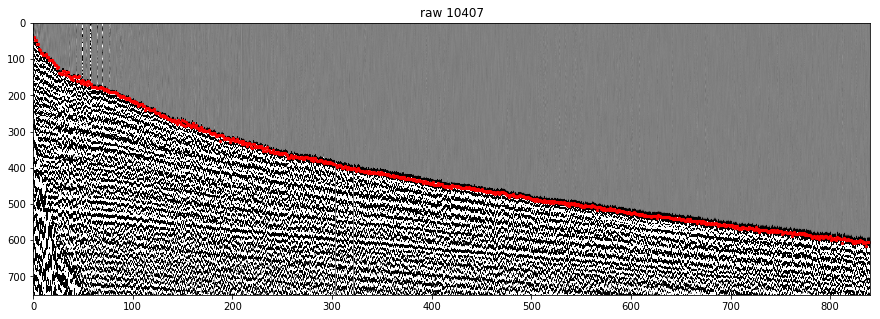

In [185]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
markup_path = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

cv = 1000
(Dataset(index, SeismicBatch).next_batch(batch_size=1, n_epochs=None)
             .load(components='raw', fmt='segy')
             .load(components='markup', fmt='picks')
             .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                           figsize=(15,5), vmax=cv, vmin=-cv, s=5, c='r'))

Set train and test fields

In [186]:
train_index = index.create_subset(index.indices[:250])
train_data = Dataset(TraceIndex((train_index)), my_batch)

In [177]:
test_index = index.create_subset(index.indices[250:260])
test_data = Dataset(TraceIndex((test_index)), my_batch)

## Model Architecture

We are using Unet type of model with 4 blocks

In [5]:
inputs_config = {
    'raw1': {'shape': (1, 753)}, #753 PAL
    'mask': {'shape': (1, 753),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

In [11]:
%env CUDA_VISIBLE_DEVICES=6
config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw1',
    'optimizer': ('Adam', {'lr': 0.01}),
    'head/num_classes': 2, 
    'body/num_blocks': 4,
    'body/filters': [8, 16, 32, 64], #[10, 14, 18, 22]
    'body/encoder': dict(layout='cna cna', kernel_sizee=5),
    'body/decoder': dict(layout='cna cna', kernel_size=5),
    'device': 'cuda',
}

env: CUDA_VISIBLE_DEVICES=6


## Training

There are some load and data processing actions in the pipeline.

In [13]:
train_pipeline = (train_data.p
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=500, src='raw')
                      .get_mask(src='markup', dst='mask1')
                      .normalize_traces(src='raw', dst='raw')
                      .process_component(src='raw', dst='raw1', add_dim=True)
                      .process_component(src='mask1', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .train_model('my_model', B('raw1'), B('mask'), #make_data=make_data, 
                                   fetches='loss', save_to=V('loss'), mode='a'))

In [187]:
train_pipeline.run(batch_size=256, n_epochs=3, shuffle=True, bar=True)

100%|█████████▉| 435/436 [04:53<00:00,  1.54it/s]


Loss function plot

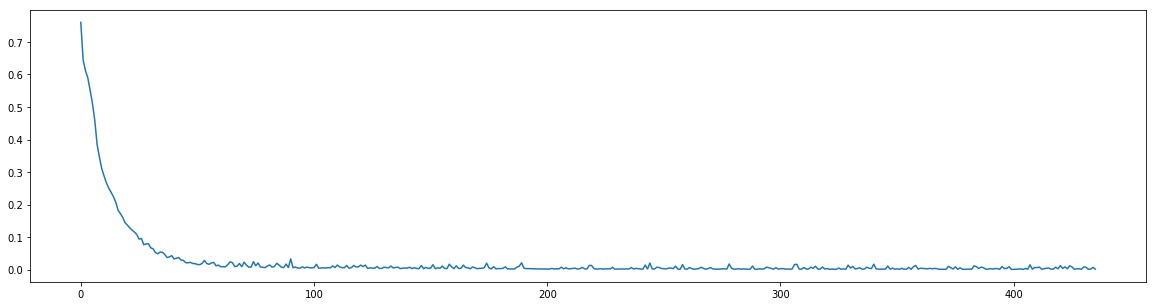

In [16]:
loss = train_pipeline.get_variable('loss')
plt.figure(figsize=(20, 5))
plt.plot(loss)

Save the model.

In [33]:
train_pipeline.save_model('my_model', path="picks_modelUNet_ker5.dill")

## Inference

Inference pipeline:

In [66]:
model_path = "picks_modelUNet_ker5.dill"
config_predict = {
    'build': False,
    'load': {'path': model_path},
    'device': 'cuda'
}

test_pipeline = (test_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config_predict) 
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .get_mask(src='markup', dst='mask1')
                      .normalize_traces(src='raw', dst='raw')
                      .init_variable('traces', init_on_each_run=list())
                      .update_variable('traces', B('raw'), mode='a')
                      .process_component(src='raw', dst='raw1', add_dim=True)
                      .process_component(src='mask1', dst='mask')
                      .init_variable('picking', init_on_each_run=list())
                      .update_variable('picking', B('mask'), mode='a')
                      .add_components(components='unet_predictions')
                      .predict_model('my_model', B('raw1'),
                                     fetches=['predictions'],  save_to=[B('unet_predictions')], mode='a')
                      .apply_transform(func= mass_ones, thd=0.5, src='unet_predictions', dst='unet_predictions')
                      .init_variable('predictions', init_on_each_run=list())
                      .update_variable('predictions', B('unet_predictions'), mode='a'))

In [178]:
test = (test_pipeline << test_data).run(500, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 94%|█████████▍| 16/17 [00:22<00:01,  1.49s/it]


## Model evaluation
### Palian dataset

In [ ]:
pred = test.get_variable('predictions')
pred = np.concatenate(pred)

true = test.get_variable('picking')
true = np.vstack(true)
true = np.argmax(true, axis=1)

traces = test.get_variable('traces')
raw = np.vstack(np.concatenate(traces))

Take a look at some metrics.   
MAE stands for Mean Absolute Error - how much model picking deviates from ground trurh on the avarage in absolute terms

In [89]:
def MAE(x,y):
    return np.sum(abs(x - y)) / len(x)

In [183]:
print('MAE on Palian test: {0:.3f}'.format(MAE(true, pred)))

MAE on test: 0.083


Even though picking is a regression task, we can consider its classification interpretation.   
If ground truth and model picking differs more than 3 in absolute terms - we consider such trace as not properly classified.

In [180]:
def accuracy(x, y):
    diff = np.abs(x - y)
    return len(diff[diff<3]) / len(diff)

In [184]:
print('Accuracy on Palian test: {0:.3f}'.format(accuracy(pred, true)))

Accuracy on test: 0.993


### BLUE - PREDICTED
### RED - GROUND TRUTH

Take a look  at the whole seismograms

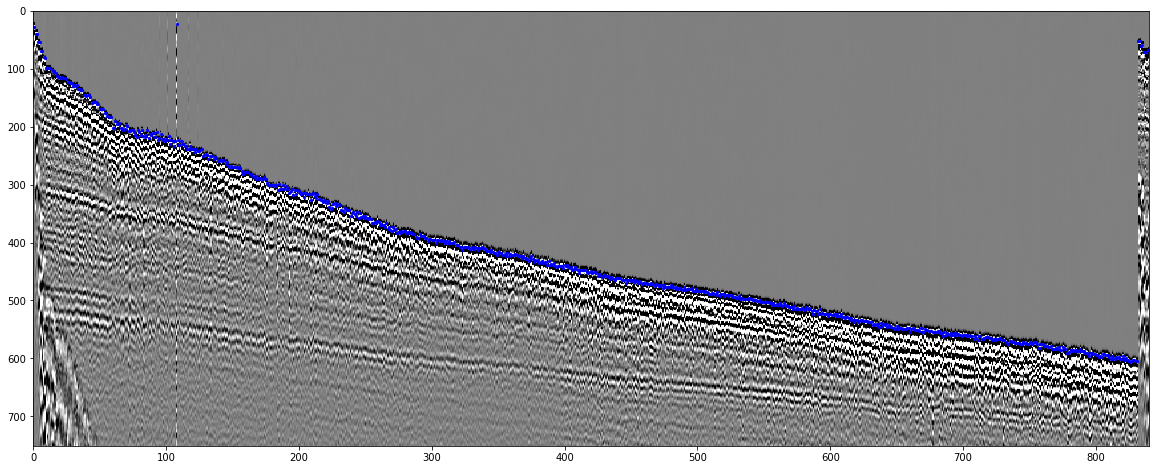

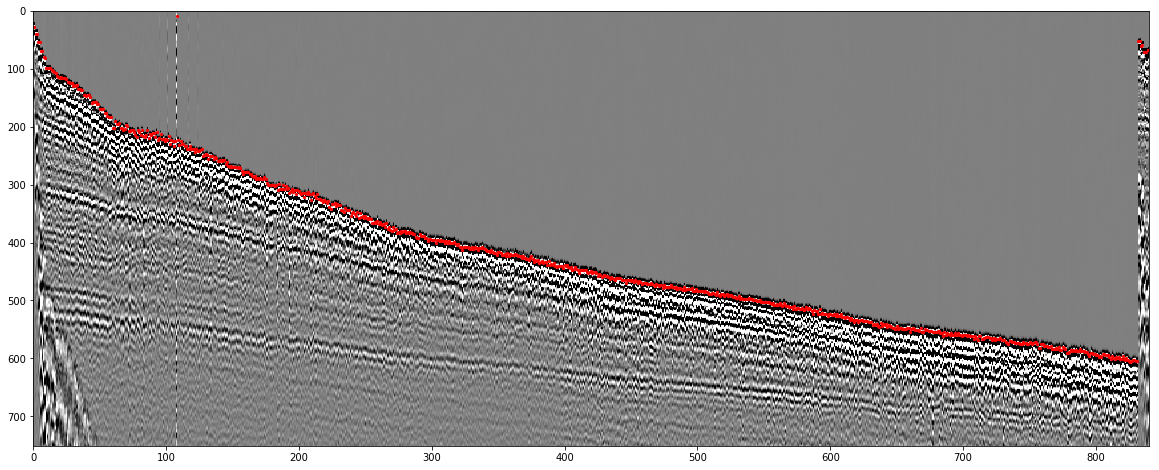

In [91]:
ind = range(840)
cv = 1
pts = (range(len(pred[ind])), pred[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 5, c = 'b', figsize=(20, 8))
pts = (range(len(true[ind])), true[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 5, c = 'r', figsize=(20, 8))

### 10 most poorly predicted traces

Take a look at 10 traces where the model mistakes the most.

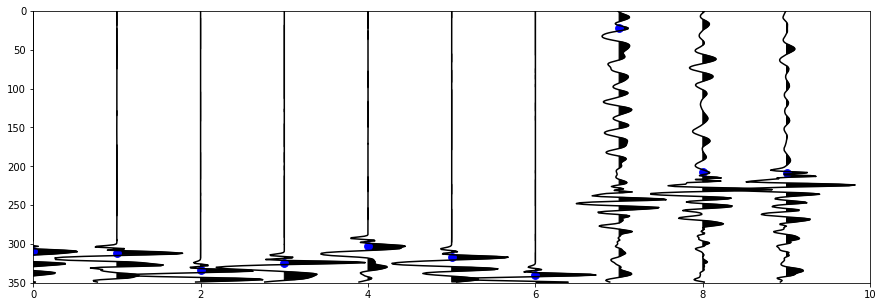

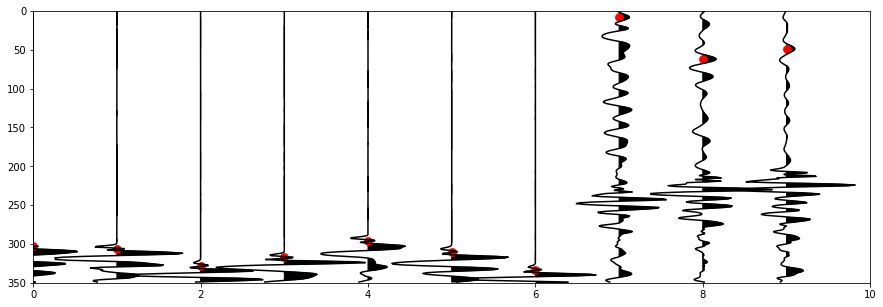

In [104]:
difference = abs(true-pred)
worst = difference.argsort()[-10:]
ylim = (0, 350)
s = 60
std = 0.1
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(pred[worst])), pred[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c='b', std = std, ylim=ylim)
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(true[worst])), true[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c='r', std = std, ylim=ylim)

### Worst predicted trace and its direct neighboors

Take a closer look at the "worst trace" and its neighboots.   
#### It turns out that the model DOES NOT mistake in this case. Sometimes ground truth picking is not correct

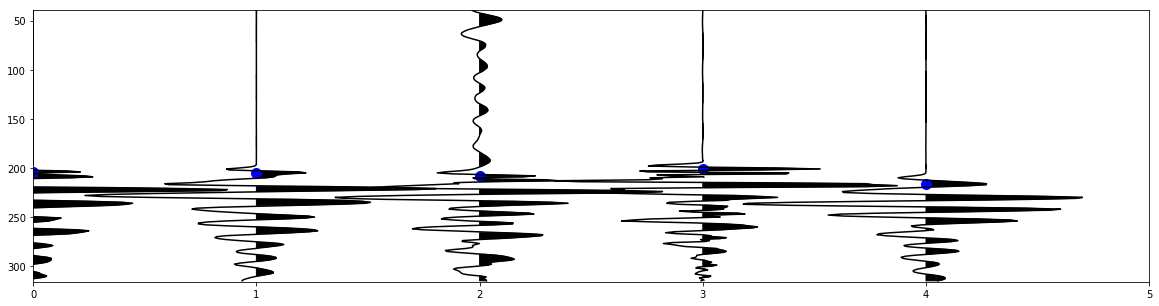

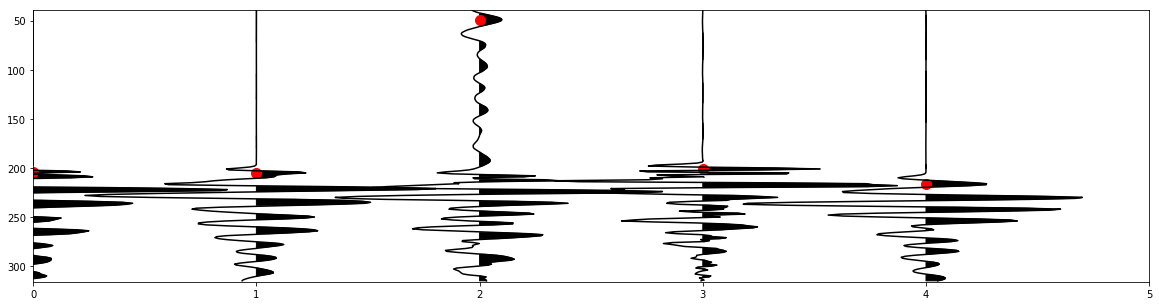

In [100]:
k = 9
nworst = [worst[k] - 2, worst[k] - 1, worst[k], worst[k] + 1, worst[k] + 2]
ylim = (min(np.concatenate((true[nworst], pred[nworst]))) - 10, max(np.concatenate((true[nworst], pred[nworst]))) + 100)
s = 100
std = 0.1
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(pred[nworst])), pred[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, c='b', std = std, ylim=ylim)
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(true[nworst])), true[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, c='r', std = std, ylim=ylim)

### WZ Dataset

Same steps for WZ dataset.

In [207]:
path_raw = '/notebooks/egor/FB/WZ/WZ_Flatiron_1k.sgy'
markup_path='/notebooks/egor/FB/WZ/WZ_Flatiron_1k_picking.csv'

We will validate our model quality on the 50 seismograms.

In [208]:
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
test_index = index.create_subset(index.indices[:50])
test_data = Dataset(TraceIndex((test_index)), my_batch)

In [209]:
test = (test_pipeline << test_data).run(500, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 99%|█████████▊| 74/75 [01:46<00:01,  1.47s/it]


In [210]:
pred = test.get_variable('predictions')
pred = np.concatenate(pred)

true = test.get_variable('picking')
true = np.vstack(true)
true = np.argmax(true, axis=1)

traces = test.get_variable('traces')
raw = np.vstack(np.concatenate(traces))

Metrics

In [211]:
mask = true > 0
true = true[mask]
pred = pred[mask]
raw = raw[mask]
print('MAE on WZ test: {0:.3f}'.format(MAE(true, pred)))

MAE on WZ test: 0.820


In [212]:
print('Accuracy on WZ test: {0:.3f}'.format(accuracy(pred, true)))

Accuracy on WZ test: 0.953


Whole seismograms.

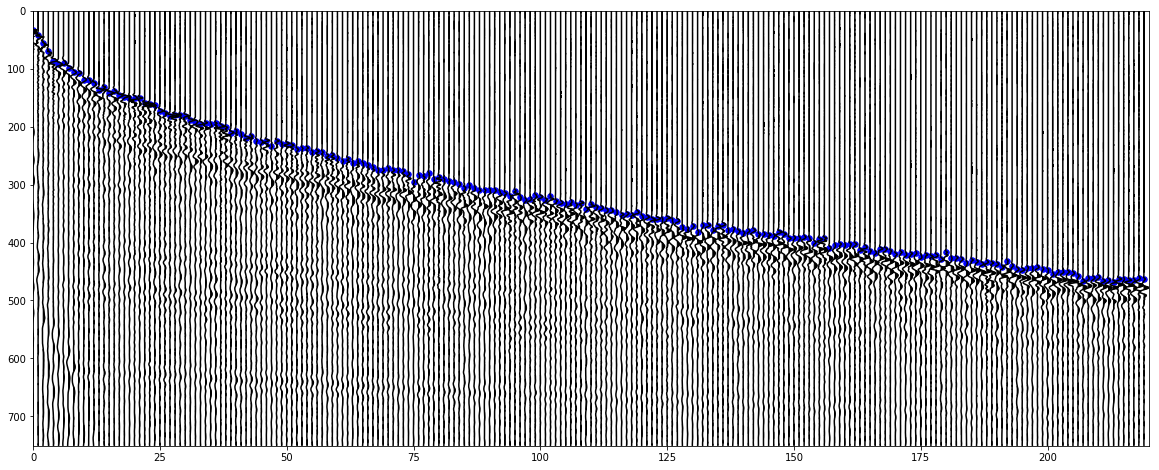

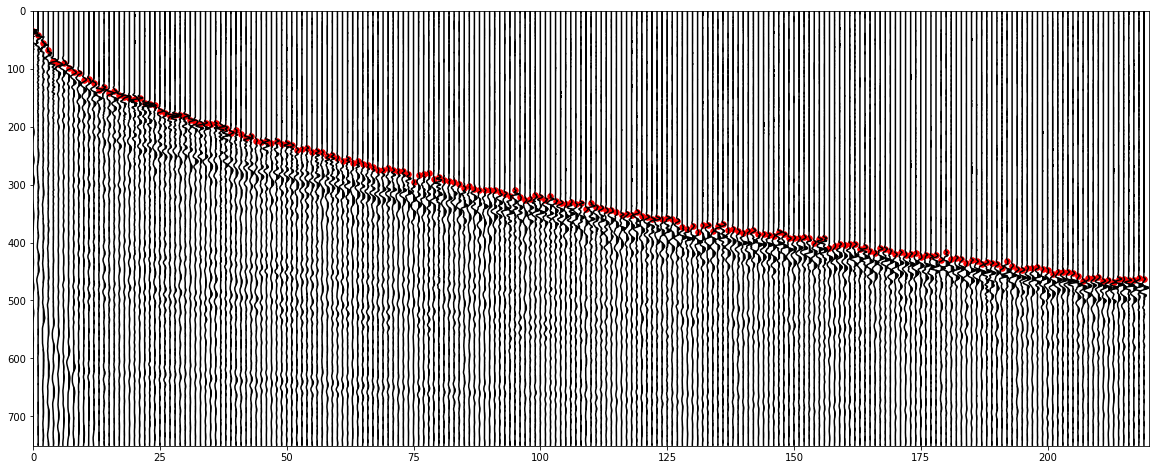

In [216]:
ind = range(220)
cv = 1
pts = (range(len(pred[ind])), pred[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 30, c = 'b', figsize=(20, 8), wiggle=True, std=0.1)
pts = (range(len(true[ind])), true[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 30, c = 'r', figsize=(20, 8), wiggle=True, std=0.1)

#### 10 most badly predicted traces

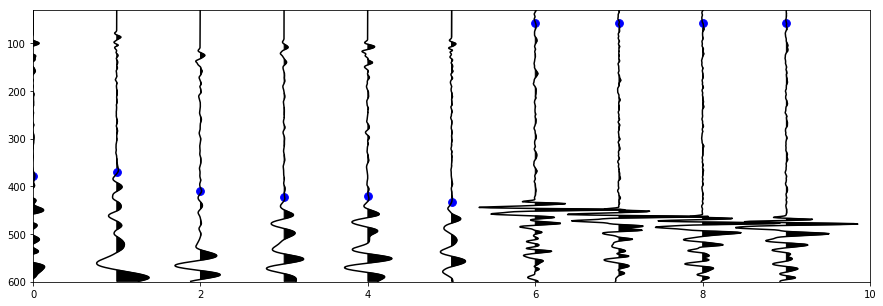

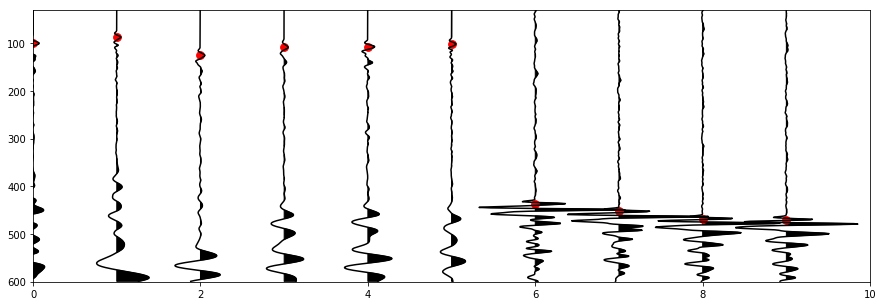

In [214]:
difference = abs(true-pred)
worst = difference.argsort()[-10:]

ylim = (30, 600)
s = 60
std = 0.1
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(pred[worst])), pred[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c='b', std = std, ylim=ylim)
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(true[worst])), true[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c='r', std = std, ylim=ylim)

#### The worst trace and its neighboors

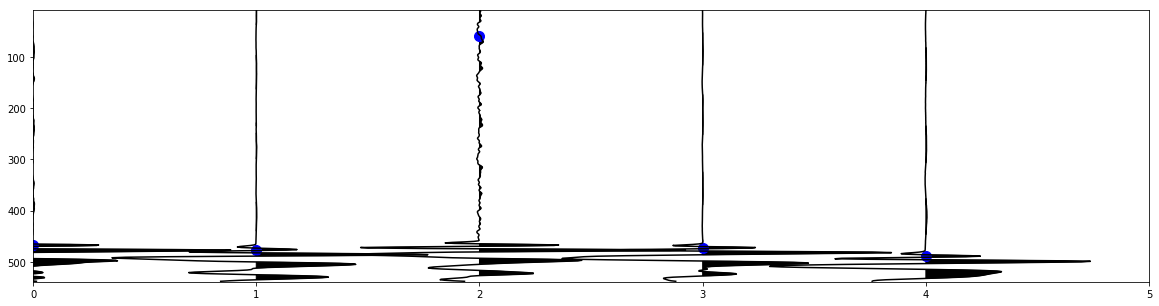

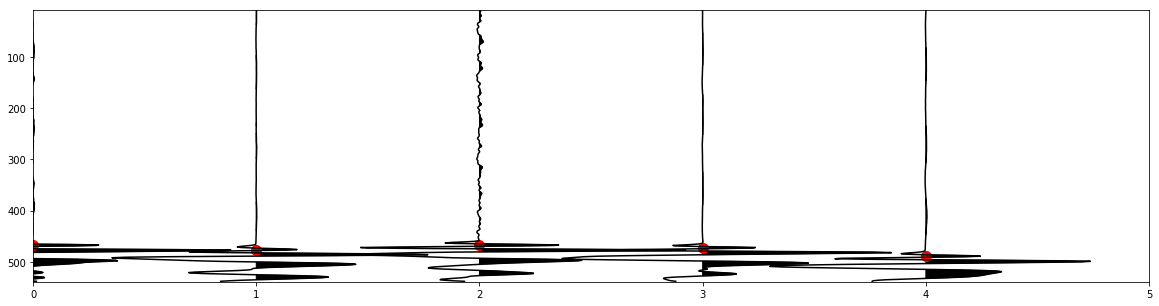

In [175]:
k = 9
nworst = [worst[k] - 2, worst[k] - 1, worst[k], worst[k] + 1, worst[k] + 2]
ylim = (min(np.concatenate((true[nworst], pred[nworst]))) - 50, max(np.concatenate((true[nworst], pred[nworst]))) + 50)
s = 100
std = 0.1
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(pred[nworst])), pred[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, c='b', std = std, ylim=ylim)
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(true[nworst])), true[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, c='r', std = std, ylim=ylim)

## Conclusion

The model finds first break picking, but it quite sencitive to the traces with the significant noise amplitudes before signal.   
The model generalises the pattern of first break picking and shows decent results in  valudation on traces from completely different terrain rather than training ones.   
However, not always correct ground truth labels and noise in the signal is two main challenges in this task.